# SNLP Assignment 4 - The Plagues of N-Gram Modelling

Name 1: William LaCroix<br/>
Student id 1: 7038732<br/>
Email 1: williamplacroix@gmail.com<br/>


Name 2: Nicholas Jennings<br/>
Student id 2: 2573492<br/>
Email 2: s8nijenn@stud.uni-saarland.de<br/>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective Python files for any additional exercises necessary. There is no need to submit the data files should they exist. <br/>
Upload the zipped folder on CMS. Please follow the naming convention of **Name1_studentID1_Name2_studentID2.zip**. Make sure to click on "Turn-in" (or the equivalent on CMS) after your upload your submission, otherwise the assignment will not be considered as submitted. Only one member of the group should make the submisssion.

---

# The Plague of OOVs (5)

Out-Of-Vocabulary words or OOVs are a major problem for any language model because of insufficent data and/or the emergence of new words. Let's see how this affects our statistical models. 

1. What happpens to the perplexity when there is an OOV in the evaluation sentence? (0.5 points)


2. The go-to solution for modelling OOVs in the N-gram setting is to introduce a new `<unk>` token in the vocabulary for all unknown words. The `<unk>` token replaces all OOVs and is then modelled like any other word. (4 points)
    - Split your data into train:test datasets using a 70:30 ratio. (0.5 points) 
    - Complete the function to create a vocabulary with the *top_n* most frequent words in the train set. (0.5 points)
    - Complete the function that restricts a corpus into the given vocabulary. (1 point)
    -  Vary *top_n* and plot how the OOV rate for the test set changes with an increase in the size of the vocabulary (use a log-log scale). What do you observe? (2 points)
  

3. A very common practice is to build the vocabulary using all words that occur twice or more in the training data. Why would we restict the vocabulary if OOVs are a headache in the first place? (0.5 points)




## 1
If a probability of zero is assigned to unknown words, the perplexity would be infinite since perplexity is calculated using negative log likelihood.

In [18]:
from collections import Counter
import oov
from importlib import reload
oov=reload(oov)
import numpy as np

#Loading the WSJ treebank, Implement preprocessing
corpus=oov.load_and_preprocess_data()

#Implement corpus splitting. Do not randomize anything here.
train,test=oov.train_test_split(corpus)

train_rates = []
test_rates = []
X = np.linspace(100,5000,10,dtype=int)

for top_n in X:
  # Create Vocabulary with most popular words in the train set
  vocab=oov.make_vocab(train,top_n)

  # Force the train data and test data into this vocabulary by replacement with '<unk>'
  vocabulary_restricted_train=oov.restrict_vocab(train,vocab)
  vocabulary_restricted_test=oov.restrict_vocab(test,vocab)

  train_oov_rate = oov.oov_rate(vocabulary_restricted_train)
  test_oov_rate = oov.oov_rate(vocabulary_restricted_test)

  train_rates.append(train_oov_rate)
  test_rates.append(test_oov_rate)



[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\William\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


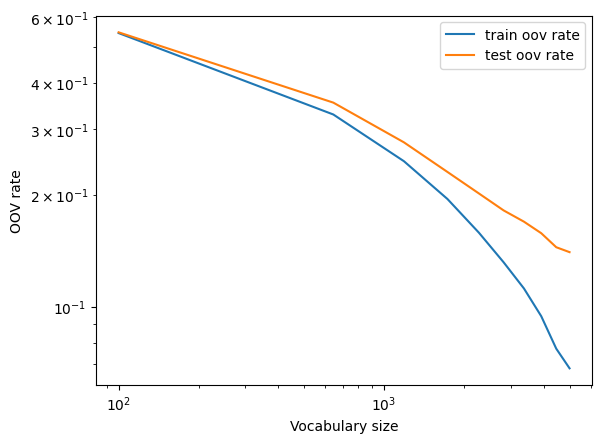

In [19]:
import matplotlib.pyplot as plt
plt.figure("plot")
plt.loglog(X, train_rates, label="train oov rate")
plt.loglog(X, test_rates, label="test oov rate")
plt.xlabel("Vocabulary size")
plt.ylabel("OOV rate")
plt.legend()

At lower vocab sizes, the test oov error rate is only slightly higher than the train oov rate, however as the vocab size increases difference between train and test error grows. The test oov rate falls at roughly the same rate throughout the graph, while test rate more sharply as the vocab size increases.

## 3
The reason to restrict the vocabulary would be to reduce overfitting on infrequent words. Moreover, even if the vocabulary is not restricted, there will "always" be words in the test set that do not occur in the train set.

# The Plague of Unseen N-Grams (5 points)

A major and very common issue with N-gram modelling is the estimation of probabilities for ngram sequences that are unobserved in the training data. The most popular technique to tackle unseen ngrams is to smooth the MLE distribution. We will deal with more complicated smoothing techniques later in the course, but let's look at a rudimentary smoothing technique called Laplace Smoothing. You can look it up in the [Jurafsky Book](https://web.stanford.edu/~jurafsky/slp3/old_dec21/3.pdf) 

The idea of Laplace smoothing is simple: You add a count of alpha to all existing bigram counts in the corpus. Consequently, you "pretend" that you observed the previously unseen ngrams **once**. For intuition, you can look at Figures 3.1 and 3.6 in the Jurafsky book. Your task now is to implement a Bigram model with add-one smoothing. 

1. The main task is to complete the `BigramModel` class in `smoothed_lm.py`. Finish the functions to count ngrams and compute the Laplace smoothed probability for a given bigram. (2 points)

2. Now calculate the average perplexity on the test set. You can start conditional probabilitity estimations from the second word (pay attention to the consequent normalization factor for perplexity). Use vocabulary-restricted train and test sets. Use a top_5000 vocabulary. (2 point).

3. What happens when you vary alpha in the range 0-1? Why is this smoothing inefficient? (1 point)

In [135]:
import smoothed_lm
from importlib import reload
smoothed_lm=reload(smoothed_lm)
from tqdm import tqdm

# Create Vocabulary with most popular 5000 words in the train set
vocab=oov.make_vocab(train,5000)

# Force the train data and test data into the vocabulry
vocabulary_restricted_train=oov.restrict_vocab(train,vocab)
vocabulary_restricted_test=oov.restrict_vocab(test,vocab)

word_perplexity_list = list()
alphas = np.linspace(0,1,100)

#Complete the class
for alpha in tqdm(alphas):
    model=smoothed_lm.BigramModel(vocabulary_restricted_train,vocabulary_restricted_test,alpha)
    model.logprob(('and','the'))
    perplexity = model.perplexity()
    #Calculate Average test perplexity
    # print("For alpha =", alpha, "perplexity is", perplexity)
    word_perplexity_list.append(perplexity)

100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


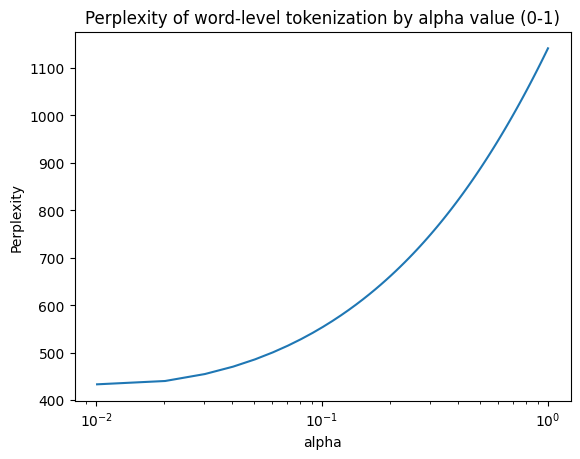

In [136]:
plt.plot(alphas, word_perplexity_list)
plt.xscale("log")
plt.ylabel("Perplexity")
plt.xlabel("alpha")
plt.title("Perplexity of word-level tokenization by alpha value (0-1)")
plt.show()

## Unseen N-grams answer: 3

For values of alpha between 0 and 1, perplexity increases monotonically, implying that the more heavy-handed smoothing (such as add-one) does a worse job modeling the data. This is because too much probability mass has been moved into unseen words. Perplexity is thus lowest at values approaching (but not reaching) zero. This avoids undefined behavior for log(0) probabilities, while shifting the least amount of probability mass away from the data seen in training.

# Bonus Question - Alternate tokenizations for OOV handling (2 points)

We saw in the first part that the OOV issue can be mitigated by using the `<unk>` token. Another option to deal with the OOV problem is to change your tokenization schema by making it more granular. A very popular method along these lines is subword modelling. The idea here is simple: you tokenize your sentence into a sequence of sub-words and subsequently span your vocabulary across all possible subwords in the corpus. This makes sure that there is no OOV in the test set, since new words are still composed of the subwords in your vocabulary. 


1. Tokenize the corpus using character-level tokenization and compute the perplexity of the resulting bigram model. (0.5 points)

2. Extend this to another tokenization scheme: The very popular [Byte-Pair Encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt) schema used these days. You can use Huggingface's [GPT2Tokenizer](https://huggingface.co/transformers/v3.0.2/model_doc/gpt2.html#gpt2tokenizer) to do this.  Find the resulting bigram model perplexity. (0.5 points)

3. Can you compare these perplexities? In general, is it okay to compare perplexities when we use different tokenization schemes? (1 point)


In [138]:
import bonus
bonus = reload(bonus)
import smoothed_lm
smoothed_lm=reload(smoothed_lm)
# Force the train data and test data into the vocabulry
character_tokens_train=bonus.char_tokenize(train)
character_tokens_test=bonus.char_tokenize(test)

character_perplexity_list = list()
alphas = np.linspace(0,1,100)

#Complete the class
for alpha in tqdm(alphas):
    char_model=smoothed_lm.BigramModel(character_tokens_train, character_tokens_test, alpha)
    perplexity = char_model.perplexity()
    #Calculate Average test perplexity
    #print("For alpha =", alpha, "perplexity is", perplexity)
    character_perplexity_list.append(perplexity)

100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


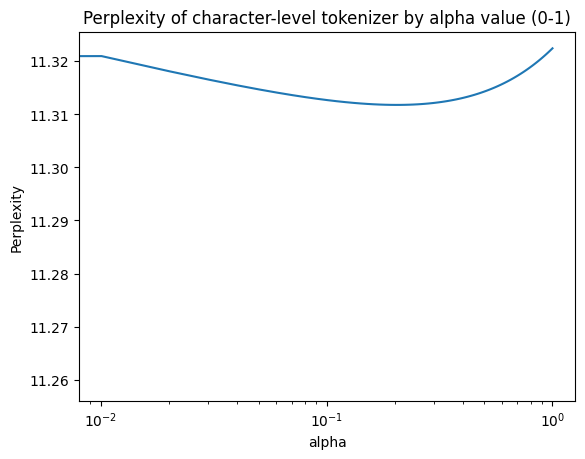

In [139]:
plt.plot(alphas, character_perplexity_list)
plt.xscale("log")
plt.ylabel("Perplexity")
plt.xlabel("alpha")
plt.title("Perplexity of character-level tokenizer by alpha value (0-1)")
plt.show()

In [141]:
import bonus
bonus = reload(bonus)
import smoothed_lm
smoothed_lm=reload(smoothed_lm)
# Force the train data and test data into the vocabulry
byte_pair_tokens_train=bonus.byte_pair_tokenize(train)
byte_pair_tokens_test=bonus.byte_pair_tokenize(test)

byte_pair_perplexity_list = list()
alphas = np.linspace(0,1,100)

#Complete the class
for alpha in tqdm(alphas):
    byte_pair_model=smoothed_lm.BigramModel(byte_pair_tokens_train,byte_pair_tokens_test,alpha)
    perplexity = byte_pair_model.perplexity()
    #Calculate Average test perplexity
    #print("For alpha =", alpha, "perplexity is", perplexity)
    byte_pair_perplexity_list.append(perplexity)

100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


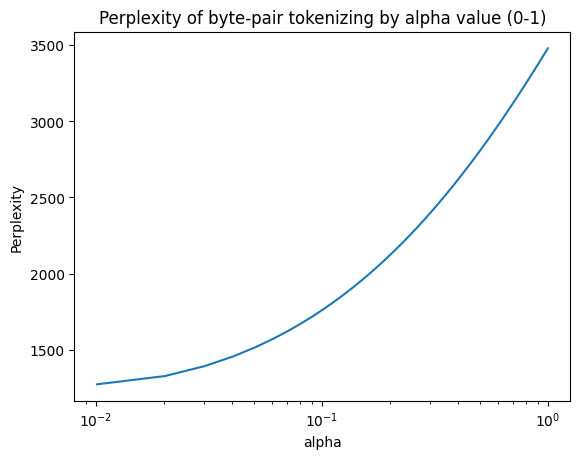

In [142]:
plt.plot(alphas, byte_pair_perplexity_list)
plt.xscale("log")
plt.ylabel("Perplexity")
plt.xlabel("alpha")
plt.title("Perplexity of byte-pair tokenizing by alpha value (0-1)")
plt.show()

### 3. Can you compare these perplexities? In general, is it okay to compare perplexities when we use different tokenization schemes?

Hell naw! For one, the scales are completely different (look at those beautiful y-axes!). And just because a model can learn to predict characters in a word, that has nothing to do with predicting word-to-word relationships.